In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd

import copy
import traceback
import datetime
import joblib
import re
import os
import random
import string
import time

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchtext import data
from torchtext import datasets
from torchtext import vocab
from torchtext.vocab import Vectors, GloVe

from tqdm.notebook import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import pymorphy2
from sklearn.base import BaseEstimator, TransformerMixin

import gensim

In [3]:
class ConfigExperiment:
    seed = 42
    positive_file = "../data/positive.csv"
    negative_file = "../data/negative.csv"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    embed_dim = 300
    max_vocab_size = 50_000
    batch_size = 2048
    num_epochs = 50
    lr = 1e-2
    num_workers = 0
    patience = 5
    early_stopping_delta = 2
    save_dirname = "models"
    
config = ConfigExperiment()

In [4]:
def init_random_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic=True
    
init_random_seed(config.seed)

In [5]:
train = pd.read_csv("../data/train_processed_data_regression.csv", index_col=False)
validate = pd.read_csv("../data/validate_processed_data_regression.csv", index_col=False)
test = pd.read_csv("../data/test_processed_data_regression.csv", index_col=False)

In [6]:
train.head()

,text,target,tstcount,tfoll,tfrien,listcount
0,оставаться самый нужный и самый близкие ) весь...,0,35465,118,34,2
1,"такой приятный чувство , когда ты знаешь , что...",0,1484,22,22,0
2,день начинаться с лень вообще ничто делать не ...,0,2,0,0,0
3,at_user at_user ксюша поход вплотную там суп з...,0,3621,148,146,2
4,"at_user с днём рождение at_user , творческий у...",1,1707,44,66,3


In [9]:
train['logtarget'] = np.log1p(train['target']).astype('float32')
validate['logtarget'] = np.log1p(validate['target']).astype('float32')
test['logtarget'] = np.log1p(test['target']).astype('float32')

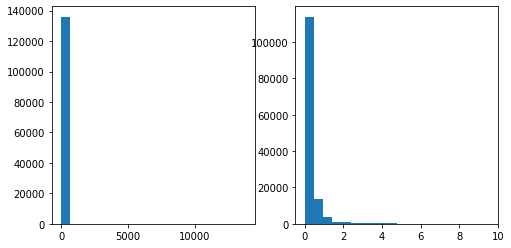

In [10]:
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(train["target"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(train['logtarget'], bins=20);

### Подготовка данных

In [5]:



tokenize = lambda x: str(x).split()
TEXT = data.Field(
    sequential=True,
    use_vocab=True,
    lower=False,
    tokenize=tokenize, 
    batch_first=True,
    pad_token='PAD',
    unk_token='UNK',
)
# число всех сообщений пользователя в сети twitter;
TSTCOUNT = data.Field(sequential=False, use_vocab=False, dtype=torch.float)
# количество фоловеров пользователя (тех людей, которые читают пользователя);
TFOLL = data.Field(sequential=False, use_vocab=False, dtype=torch.float)
# количество друзей пользователя (те люди, которых читает пользователь);
TFRIEN = data.Field(sequential=False, use_vocab=False, dtype=torch.float)
# количество листов-подписок в которые добавлен твиттер-пользователь.
LISTCOUNT = data.Field(sequential=False, use_vocab=False, dtype=torch.float)
# число ретвитов
TARGET = data.Field(sequential=False, use_vocab=False, dtype=torch.float)

fields = [('text',TEXT), ('tstcount', TSTCOUNT), ('tfoll', TFOLL), ('tfrien', TFRIEN), ('listcount', LISTCOUNT), ('target', TARGET)]

train_data, valid_data, test_data = data.TabularDataset.splits(
    path="../data/",
    train="train_processed_data_regression.csv",
    validation="validate_processed_data_regression.csv",
    test="test_processed_data_regression.csv",
    format="csv",
    fields=fields,
    skip_header=True)

TEXT.build_vocab(train_data, min_freq=2)

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: x.text,
    batch_size=config.batch_size,
    device=config.device)

### Скачать и рапаковать предобученные веса

In [6]:
# from zipfile import ZipFile
# import wget

# model_url = 'http://vectors.nlpl.eu/repository/11/187.zip'
# wget.download(model_url)
# with ZipFile('187.zip', 'r') as zipObj:
#    # Extract all the contents of zip file in different directory
#    zipObj.extractall('187')

### Составить матрицу предобученных весов для словаря 

In [7]:
w2v_model = gensim.models.KeyedVectors.load('187/model.model')
numpy_embeddings = np.zeros(shape=[len(TEXT.vocab), config.embed_dim],dtype=np.float32)

for word in TEXT.vocab.itos:
    vector = w2v_model.get_vector(word)
    index  = TEXT.vocab.stoi[word]
    numpy_embeddings[index] = vector
    
pretrained_embeddings = torch.Tensor(numpy_embeddings).float()
pretrained_embeddings.shape

torch.Size([33041, 300])

### Создание модели

In [8]:
class MultymodalNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, hidden, output_dim, dropout, pad_idx):
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, 
                      out_channels=n_filters, 
                      kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc_text = nn.Linear(len(filter_sizes) * n_filters, hidden)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden + 4, output_dim)

    def forward(self, text, tstcount, tfoll, tfrien, listcount):
        
        tstcount, tfoll, tfrien, listcount = tstcount.unsqueeze(1), tfoll.unsqueeze(1), tfrien.unsqueeze(1), listcount.unsqueeze(1)
        
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)  
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.permute(0, 2, 1)
        #embedded = [batch size, emb dim, sent len]
        
        conved = [F.relu(conv(embedded)) for conv in self.convs]
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim=1))
        #cat = [batch size, n_filters * len(filter_sizes)]
        
        text_features = self.dropout(self.fc_text(cat))
        
        cat = torch.cat([text_features, tstcount, tfoll, tfrien, listcount], dim=1)

        result = self.fc(cat)
            
        return result


In [9]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = config.embed_dim
N_FILTERS = 128
FILTER_SIZES = [2, 3]
HIDDEN = 256
OUTPUT_DIM = 1
DROPOUT = 0.5

PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

In [10]:
model = MultymodalNet(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, HIDDEN, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [11]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,170,609 trainable parameters


### Копирование предобученных весов в модель

In [12]:
model.embedding.weight.data.copy_(pretrained_embeddings)

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [13]:
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, mode="max", factor=0.3)

model = model.to(config.device)
criterion = criterion.to(config.device)

In [14]:
class Trainer:
    def __init__(self, model, train_dataloader: DataLoader, valid_dataloader: DataLoader, 
                 criterion, optimizer, scheduler, config: ConfigExperiment, model_name: str):
        self.model = model
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = config.device
        self.config = config
        self.threshold = 0.5
        self.model_name = model_name
        self.train_metrics = {
            'avg_loss': [],
            'mean_squared_error': [],
            'mean_absolute_error': [],
        }
        self.valid_metrics = {
            'avg_loss': [],
            'mean_squared_error': [],
            'mean_absolute_error': [],
        }
        self.counter = 0
        self.delta = config.early_stopping_delta
      
    def run(self):
        self.model.to(self.device)
        best_valid_loss = float('inf')
        best_target_metric = float('inf')

        try:
            for i_epoch in tqdm(range(self.config.num_epochs), desc='Epochs', total=config.num_epochs, position=1, leave=True):
                start_time = time.time()

                train_loss, train_outputs, train_targets = self._train()
                valid_loss, valid_outputs, valid_targets = self._evaluate()
                    
                self.train_metrics["avg_loss"].append(train_loss)
                self.train_metrics["mean_squared_error"].append(mean_squared_error(train_targets, train_outputs.round()))
                self.train_metrics["mean_absolute_error"].append(mean_absolute_error(train_targets, train_outputs.round()))
                
                self.valid_metrics["avg_loss"].append(valid_loss)
                self.valid_metrics["mean_squared_error"].append(mean_squared_error(valid_targets, valid_outputs.round()))
                self.valid_metrics["mean_absolute_error"].append(mean_absolute_error(valid_targets, valid_outputs.round()))
                
                end_time = time.time()
                epoch_mins, epoch_secs = self._epoch_time(start_time, end_time)
                self.print_progress(i_epoch, epoch_mins, epoch_secs)
                
                self.scheduler.step(self.valid_metrics["mean_squared_error"][-1])
                
                if valid_loss < best_valid_loss:
                    best_valid_loss = valid_loss
                    torch.save(model.state_dict(), f"{config.save_dirname}/{self.model_name}.pth")
                    
                if self.valid_metrics["mean_squared_error"][-1] < best_target_metric:
                    self.counter = 0
                    best_target_metric = self.valid_metrics["mean_squared_error"][-1]
                    torch.save(model.state_dict(), f"{config.save_dirname}/{self.model_name}.pth")
                else:
                    self.counter += 1
                    
                if self.counter > self.config.patience:
                    print("EarlyStopping")
                    break
        except KeyboardInterrupt:
            pass
        
        return self.train_metrics, self.valid_metrics
        
    def _train(self):
        model.train()
        epoch_loss = 0
        epoch_output = None
        epoch_target = None
        for i, batch in tqdm(enumerate(self.train_dataloader), desc='Train', total=len(self.train_dataloader), position=2, leave=True):
            loss_iten, outputs = self._train_process(batch)
            epoch_loss += loss_iten 

            if epoch_output is None:
                epoch_output = outputs.cpu().data
            else:
                epoch_output = torch.cat((epoch_output, outputs.cpu().data))

            if epoch_target is None:
                epoch_target = batch.target.cpu().data
            else:
                epoch_target = torch.cat((epoch_target, batch.target.cpu().data))
            
        return epoch_loss / len(self.train_dataloader), epoch_output, epoch_target
    
    def _train_process(self, batch):      
        self.optimizer.zero_grad()
        outputs = self.model(batch.text, batch.tstcount, batch.tfoll, batch.tfrien, batch.listcount).squeeze(1)
        loss = self.criterion(outputs, batch.target)
        loss.backward()
        self.optimizer.step()
        return loss.item(), outputs
            
    def _evaluate(self):
        self.model.eval()
        epoch_loss = 0
        epoch_output = None
        epoch_target = None
        with torch.no_grad():
            for i, batch in tqdm(enumerate(self.valid_dataloader), desc='Valid', total=len(self.valid_dataloader), position=3, leave=True):
                outputs = self.model(batch.text, batch.tstcount, batch.tfoll, batch.tfrien, batch.listcount).squeeze(1)
                loss = criterion(outputs, batch.target)
                epoch_loss += loss.item()
                
                if epoch_output is None:
                    epoch_output = outputs.cpu().data
                else:
                    epoch_output = torch.cat((epoch_output, outputs.cpu().data))

                if epoch_target is None:
                    epoch_target = batch.target.cpu().data
                else:
                    epoch_target = torch.cat((epoch_target, batch.target.cpu().data))

        return epoch_loss / len(self.valid_dataloader), epoch_output, epoch_target
 
    def _epoch_time(self, start_time, end_time):
        elapsed_time = end_time - start_time
        elapsed_mins = int(elapsed_time / 60)
        elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
        return elapsed_mins, elapsed_secs

    def print_progress(self, i_epoch, epoch_mins, epoch_secs):
        if type(i_epoch) != str:
            i_epoch = i_epoch + 1
            print(f"Epoch: {i_epoch:02} | Time: {epoch_mins}m {epoch_secs}s")
            print("Training Results - Average Loss: {:.4f} | MSE: {:.4f} | MAE: {:.4f}"
                .format(
                    self.train_metrics['avg_loss'][-1], 
                    self.train_metrics['mean_squared_error'][-1],
                    self.train_metrics['mean_absolute_error'][-1],
                ))      
        else:
            print(f"Epoch: {i_epoch} | Time: {epoch_mins}m {epoch_secs}s")
        print("Evaluating Results - Average Loss: {:.4f} | MSE: {:.4f} | MAE: {:.4f}"
            .format( 
                self.valid_metrics['avg_loss'][-1],
                self.valid_metrics['mean_squared_error'][-1],
                self.valid_metrics['mean_absolute_error'][-1],
            ))
        print()

    def set_model(self, model: nn.Module):
        self.model = model
        
    def evaluate(self, dataloader: DataLoader):
        self.valid_dataloader = dataloader
        self.model.to(self.device)
        start_time = time.time()

        valid_loss, valid_outputs, valid_targets = self._evaluate()

        self.valid_metrics["avg_loss"].append(valid_loss)
        self.valid_metrics["mean_squared_error"].append(mean_squared_error(valid_targets, valid_outputs.round()))
        self.valid_metrics["mean_absolute_error"].append(mean_absolute_error(valid_targets, valid_outputs.round()))

        end_time = time.time()
        epoch_mins, epoch_secs = self._epoch_time(start_time, end_time)
        self.print_progress("evaluate", epoch_mins, epoch_secs)


In [15]:
trainer = Trainer(model, train_iterator, valid_iterator, criterion, optimizer, scheduler, config, "08_retweet_regression")
trainer.run();


Epoch: 01 | Time: 0m 11s
Training Results - Average Loss: 288557.1224 | MSE: 290684.1250 | MAE: 199.4011
Evaluating Results - Average Loss: 32070.6077 | MSE: 31261.2969 | MAE: 70.2334




Epoch: 02 | Time: 0m 11s
Training Results - Average Loss: 22561.9447 | MSE: 22555.3359 | MAE: 36.4186
Evaluating Results - Average Loss: 12858.9023 | MSE: 12469.7070 | MAE: 19.7758




Epoch: 03 | Time: 0m 10s
Training Results - Average Loss: 11975.3450 | MSE: 12038.7266 | MAE: 16.9074
Evaluating Results - Average Loss: 8141.9777 | MSE: 7928.2402 | MAE: 11.3312




Epoch: 04 | Time: 0m 10s
Training Results - Average Loss: 8901.5260 | MSE: 8937.6729 | MAE: 11.0753
Evaluating Results - Average Loss: 6637.4767 | MSE: 6473.6445 | MAE: 11.1408

Epoch     4: reducing learning rate of group 0 to 3.0000e-04.



Epoch: 05 | Time: 0m 10s
Training Results - Average Loss: 8001.5093 | MSE: 8034.4922 | MAE: 11.0312
Evaluating Results - Average Loss: 6485.2440 | MSE: 6322.3232 | MAE: 9.8907




Epoch: 06 | Time: 0m 10s
Training Results - Average Loss: 7879.0872 | MSE: 7914.9585 | MAE: 10.2738
Evaluating Results - Average Loss: 6342.6995 | MSE: 6168.5972 | MAE: 9.8969




Epoch: 07 | Time: 0m 10s
Training Results - Average Loss: 8012.0428 | MSE: 7992.4619 | MAE: 10.5537
Evaluating Results - Average Loss: 6270.4292 | MSE: 6109.7871 | MAE: 9.7517

Epoch     7: reducing learning rate of group 0 to 9.0000e-05.



Epoch: 08 | Time: 0m 10s
Training Results - Average Loss: 7630.3020 | MSE: 7685.1436 | MAE: 10.2623
Evaluating Results - Average Loss: 6256.5364 | MSE: 6101.3745 | MAE: 9.9053




Epoch: 09 | Time: 0m 10s
Training Results - Average Loss: 7816.2826 | MSE: 7712.9424 | MAE: 10.4389
Evaluating Results - Average Loss: 6244.3377 | MSE: 6098.4082 | MAE: 9.9423




Epoch: 10 | Time: 0m 10s
Training Results - Average Loss: 7702.6768 | MSE: 7714.5239 | MAE: 10.4187
Evaluating Results - Average Loss: 6226.6735 | MSE: 6081.2632 | MAE: 9.8693

Epoch    10: reducing learning rate of group 0 to 2.7000e-05.



Epoch: 11 | Time: 0m 10s
Training Results - Average Loss: 7630.8547 | MSE: 7655.8203 | MAE: 10.2930
Evaluating Results - Average Loss: 6217.7912 | MSE: 6070.5459 | MAE: 9.8863




Epoch: 12 | Time: 0m 10s
Training Results - Average Loss: 7594.4171 | MSE: 7649.3447 | MAE: 10.3267
Evaluating Results - Average Loss: 6217.3406 | MSE: 6073.6045 | MAE: 9.9325




Epoch: 13 | Time: 0m 10s
Training Results - Average Loss: 7597.7862 | MSE: 7652.7183 | MAE: 10.3407
Evaluating Results - Average Loss: 6213.8818 | MSE: 6071.9419 | MAE: 9.9629

Epoch    13: reducing learning rate of group 0 to 8.1000e-06.



Epoch: 14 | Time: 0m 10s
Training Results - Average Loss: 9050.4791 | MSE: 7642.3149 | MAE: 10.3689
Evaluating Results - Average Loss: 6213.9913 | MSE: 6073.5796 | MAE: 9.9914




Epoch: 15 | Time: 0m 10s
Training Results - Average Loss: 7588.6746 | MSE: 7642.6548 | MAE: 10.3968
Evaluating Results - Average Loss: 6214.1455 | MSE: 6074.8267 | MAE: 9.9962




Epoch: 16 | Time: 0m 10s
Training Results - Average Loss: 7580.9960 | MSE: 7641.0479 | MAE: 10.3983
Evaluating Results - Average Loss: 6212.4092 | MSE: 6073.2808 | MAE: 9.9971

Epoch    16: reducing learning rate of group 0 to 2.4300e-06.



Epoch: 17 | Time: 0m 10s
Training Results - Average Loss: 7588.3112 | MSE: 7638.3872 | MAE: 10.3884
Evaluating Results - Average Loss: 6212.5468 | MSE: 6073.4424 | MAE: 9.9947

EarlyStopping



In [16]:
trainer = Trainer(model, train_iterator, valid_iterator, criterion, optimizer, scheduler, config, "08_retweet_regression")
model.load_state_dict(torch.load(f'{config.save_dirname}/08_retweet_regression.pth'))
trainer.set_model(model)
trainer.evaluate(test_iterator)


Epoch: evaluate | Time: 0m 1s
Evaluating Results - Average Loss: 12455.7946 | MSE: 12925.0811 | MAE: 10.9672

